# The Lyapunov spectrum of the Lorenz system

Here, we present a calculation of the Lyapunov spectrum of the Lorenz system, using `TaylorIntegration.jl`. Our calculation involves evaluating the 1st order variational equations for this system; the variational equations are evaluated by `TaylorIntegration.jl` via automatic differentiation techniques implemented in `TaylorSeries.jl`; this means that we don't have to calculate manually the variational equations, `TaylorIntegration.jl` does that for us! This saves time, as well as typos, which sometimes are hard to trace, especially for systems with a large number of dependent variables.

The Lorenz system is the ODE defined as:

$$
\begin{align}
    \begin{split}
    \dot x_1 &= \sigma(x_2-x_1) \\
    \dot x_2 &= x_1(\rho-x_3)-x_2 \\
    \dot x_3 &= x_1x_2-\beta x_3 
    \end{split}
\end{align}
$$

where $\sigma$, $\rho$ and $\beta$ are constant parameters.

## The setup

First, we write a Julia function which evaluates (in-place) the Lorenz system equations:

In [1]:
#Lorenz system ODE:
function lorenz!(t, x, dx)
    dx[1] = σ*(x[2]-x[1])
    dx[2] = x[1]*(ρ-x[3])-x[2]
    dx[3] = x[1]*x[2]-β*x[3]
    nothing
end

lorenz! (generic function with 1 method)

Next, we define the parameters:

In [2]:
#Lorenz system parameters
#we use the `const` prefix in order to help the compiler speed things up
const σ = 16.0
const β = 4.0
const ρ = 45.92

45.92

The initial conditions, the initial and final time are:

In [3]:
const x0 = [19.0, 20.0, 50.0] #the initial condition
const t0 = 0.0 #the initial time
const tmax = 100.0 #final time of integration

100.0

We know that the sum of the Lyapunov spectrum has to be equal to the trace of the Jacobian of the equations of motion. We will calculate this trace using `TaylorSeries.jl`, and after the numerical integration, we will come back to this value to check that this is indeed the case:

In [4]:
using TaylorSeries

In [5]:
#Calculate trace of Lorenz system Jacobian via TaylorSeries.jacobian:
xi = set_variables("δ", order=1, numvars=length(x0))
x0TN = [ x0[1]+xi[1], x0[2]+xi[2], x0[3]+xi[3] ]
dx0TN = similar(x0TN)
lorenz!(t0, x0TN, dx0TN)
lorenztr = trace(jacobian(dx0TN)) #trace of Lorenz system Jacobian matrix

-21.0

# The integration

Now, we are ready to perform the integration, using `TaylorIntegration.jl`. Normally, we would use the `taylorinteg` method in order to integrate the equations of motion; but, since we are interested in evaluating the Lyapunov spectrum, we will use the `liap_taylorinteg` method, which calculates the Lyapunov spectrum via the variational equations and Oseledets' theorem. The expansion order will be $28$; the local absolute tolerance will be $10^{-20}$. `liap_taylorinteg` will return three arrays: one with the evaluation times, one with the value of the dependent variables at the time of evaluation, and another one with the vaues of the Lyapunov spectrum at each time of the evaluation.

In [6]:
using TaylorIntegration

In [7]:
@time tv, xv, λv = liap_taylorinteg(lorenz!, x0, t0, tmax, 28, 1e-20; maxsteps=2000000);

 11.295377 seconds (219.22 M allocations: 15.129 GiB, 15.68% gc time)


The number of steps taken is:

In [8]:
length(tv)

4218

Is the final time actually the requested value?

In [9]:
tv[end] == tmax

true

What is the minimum, maximum and mean time-step?

In [10]:
minimum(diff(tv)), maximum(diff(tv)), mean(diff(tv))

(0.0018190222018432678, 0.04730949106561866, 0.023713540431586435)

What is the standard deviation of the time-step size distribution?

In [11]:
std(diff(tv))

0.006662910504132029

What is the final value for each of the exponents?

In [12]:
λv[end,:]

3-element Array{Float64,1}:
   1.53183   
  -0.00994121
 -22.5219    

What is the value of the sum of the value we obtained for the spectrum?

In [13]:
sum(λv[end,:])

-20.99999999999998

Now, is the sum of the exponents exactly equal to the trace of the Jacobian?

In [14]:
sum(λv[end,:]) == lorenztr

false

So the sum is not **exactly** equal, but is it approximately equal? What is the relative error in the computed vs the expected value?

In [15]:
rel_error = (sum(λv[end,:])-lorenztr)/lorenztr

-1.0150610510858574e-15

How does this error compare to the machine epsilon?

In [16]:
rel_error/eps()

-4.571428571428571

So the relative error in our computation for the sum of the Lyapunov spectrum is comparable to the machine epsilon.

# Visualization

Finally, we plot our results:

In [17]:
using Plots
pyplot()

Plots.PyPlotBackend()

### Lyapunov exponents vs time plot


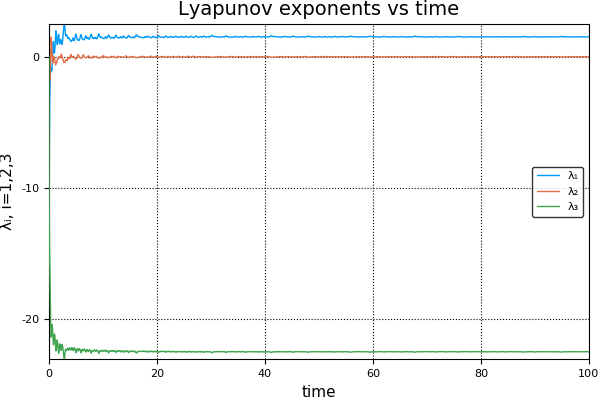

In [19]:
plot(tv, λv[:,1], label="λ₁")
plot!(tv, λv[:,2], label="λ₂")
plot!(tv, λv[:,3], label="λ₃")
xlabel!("time")
ylabel!("λᵢ, i=1,2,3")
title!("Lyapunov exponents vs time")

### Lyapunov exponents vs time plot (semi-log)


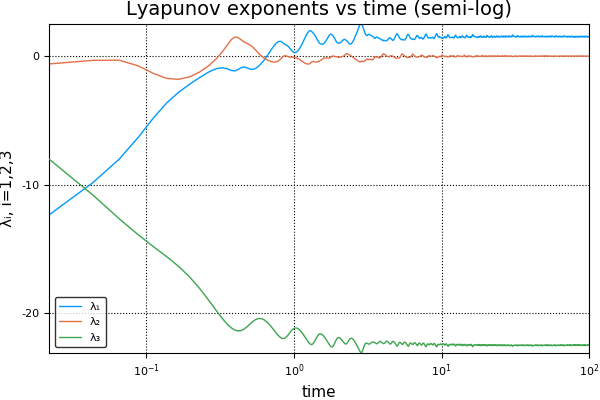

In [21]:
plot(tv[2:end], λv[:,1][2:end], xscale=:log10, label="λ₁")
plot!(tv[2:end], λv[:,2][2:end], label="λ₂")
plot!(tv[2:end], λv[:,3][2:end], label="λ₃")
xlabel!("time")
ylabel!("λᵢ, i=1,2,3")
title!("Lyapunov exponents vs time (semi-log)")

### Convergence of Lyapunov exponents vs time plot (log-log)


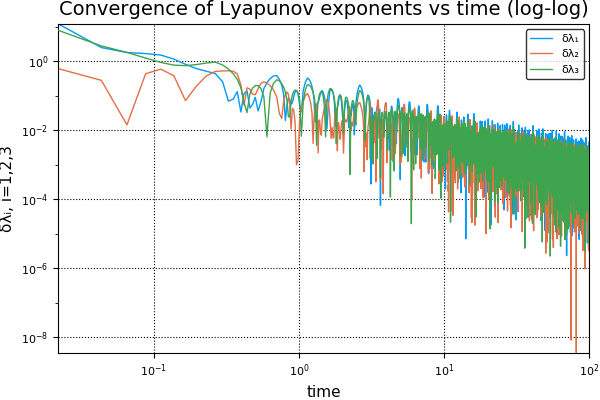

In [22]:
plot(tv[2:end], abs.(diff(λv[:,1])), yscale=:log10, xscale=:log10, label="δλ₁")
plot!(tv[2:end], abs.(diff(λv[:,2])), label="δλ₂")
plot!(tv[2:end], abs.(diff(λv[:,3])), label="δλ₃")
xlabel!("time")
ylabel!("δλᵢ, i=1,2,3")
title!("Convergence of Lyapunov exponents vs time (log-log)")

### Absolute difference wrt trace of Jacobian vs time plot (log-log)


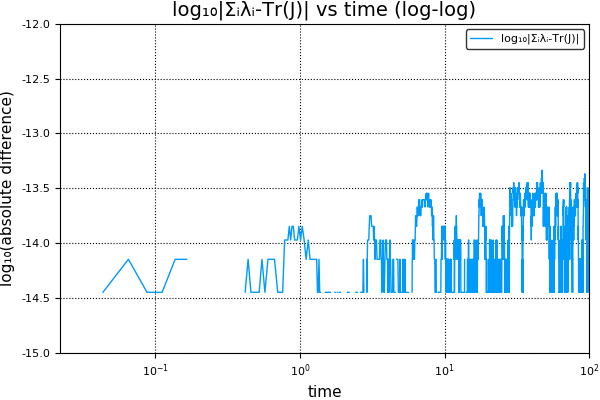

In [23]:
plot(tv[2:end], log10.(abs.(λv[2:end,1]+λv[2:end,2]+λv[2:end,3]-lorenztr)),label="log₁₀|Σᵢλᵢ-Tr(J)|", xscale=:log10)
ylims!(-15,-12)
xlabel!("time")
ylabel!("log₁₀(absolute difference)")
title!("log₁₀|Σᵢλᵢ-Tr(J)| vs time (log-log)")

## The Lorenz attractor


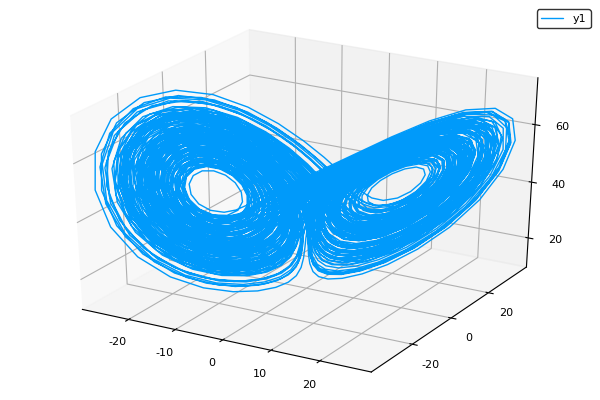

In [24]:
plot(xv[:,1], xv[:,2], xv[:,3])